### Synthetic correlations with VAEs - Simulation


Simulating correlation matrices for financial assets lacks a universally accepted approach. This project explores the use of Variational Auto-Encoders (VAEs) to generate matrices that adhere to commonly observed correlation properties. Our focus is specifically on correlations among equity indices.

One notable aspect of our approach is the potential for explainability regarding how the correlation matrix may change over time—a desirable feature for financial applications.

The data utilized in our study is sourced from Datastream.

#### Example Illustration: Italian Default Rates

In this repository, we provide an example employing other data, that are freely available. The data, obtained from https://infostat.bancaditalia.it/, pertains to Italian default rates. We employ a spline method for data elaboration in this instance. Feel free to explore and adapt our methodology for your own research and applications.

Import some packages.

In [25]:
#load appropriate packages
import torch
from torch.utils.data import BatchSampler, SequentialSampler, RandomSampler
import torch.nn as nn
import torch.nn.functional as F
import os
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')
from torch.utils.data import Dataset
from torch.utils.data import random_split
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import random

In [26]:
DIM_MAT = 32  # number of time series analyzed

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Linear(in_features=DIM_MAT * DIM_MAT, out_features=512)
        self.enc2 = nn.Linear(in_features=512, out_features=250)
        self.enc3 = nn.Linear(in_features=250, out_features=2*2)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=2, out_features=250)
        self.dec2 = nn.Linear(in_features=250, out_features=512)
        self.dec3 = nn.Linear(in_features=512, out_features=DIM_MAT * DIM_MAT)
   
    def reparameterize(self, mu, log_var):
        #param mu: mean from the encoder's latent space
        #param log_var: log var from the encoder's latent space
        
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` random number with the same size of the input
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x)) #relu activation on first encoder
        x = F.relu(self.enc2(x)) #relu activation on second encoder
        x = self.enc3(x).view(-1, 2, 2)  #apply 3th encoder without activation function (view changes the dimensions)
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
 
        # decoding
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        reconstruction = torch.sigmoid(self.dec3(x))
        return reconstruction, mu, log_var
    
    def generate(self, sample):
        # decoding
        x = F.relu(self.dec1(sample))
        x = F.relu(self.dec2(x))
        generated = torch.sigmoid(self.dec3(x))
        return generated

### Instantiate a VAE

In [27]:
device = torch.device('cpu')
myVAE = VAE().to(device)
criterion = nn.MSELoss(reduction = 'sum')
print(myVAE)

VAE(
  (enc1): Linear(in_features=1024, out_features=512, bias=True)
  (enc2): Linear(in_features=512, out_features=250, bias=True)
  (enc3): Linear(in_features=250, out_features=4, bias=True)
  (dec1): Linear(in_features=2, out_features=250, bias=True)
  (dec2): Linear(in_features=250, out_features=512, bias=True)
  (dec3): Linear(in_features=512, out_features=1024, bias=True)
)


In [28]:
myVAE.load_state_dict(torch.load('github_model_80epochs_beta_01_SEED.pth'))

<All keys matched successfully>

In [29]:
synt_44 = []
num_sim = 1000
for i in range(num_sim):
    normal = torch.from_numpy(np.random.normal(0,1,2))
    generate = myVAE.generate(normal.float())
    synt_44.append(generate)

In [30]:
print(synt_44[20].view(DIM_MAT,DIM_MAT))

tensor([[0.9983, 0.8141, 0.7809,  ..., 0.6868, 0.7430, 0.8285],
        [0.8143, 0.9982, 0.8830,  ..., 0.8116, 0.8658, 0.9275],
        [0.7747, 0.8844, 0.9983,  ..., 0.9169, 0.9601, 0.9588],
        ...,
        [0.6843, 0.8068, 0.9164,  ..., 0.9970, 0.9591, 0.8907],
        [0.7459, 0.8634, 0.9589,  ..., 0.9611, 0.9977, 0.9493],
        [0.8261, 0.9283, 0.9569,  ..., 0.8954, 0.9488, 0.9986]],
       grad_fn=<ViewBackward0>)


### Sampling a set of points from the latent space 

In [31]:
# selezione manuale in zone non mappate dalle matrici storiche
extra_points = np.array([[-1, .5], [-.5, .5], [0.5, .5], [1, .5], [1.5, .5],
                   [-1, 0], [-.5, 0], [.5, 0], [1, 0],
                   [-1, -.5], [-.5, -.5], [.5, -.5], [1, -.5],
                   [-.5, -1], [0, -1], [.5, -1], [1, -1], [-1, 1.5],
                   [-.5, -1.5], [0, -1.5], [.5, -1.5], [1, -1.5],
                    [0, -2], [.5, -2]])
#pd.DataFrame(extra_points).to_excel('extra_points.xls')
n_xp = len(extra_points)
corr_mats = np.zeros((n_xp, DIM_MAT*DIM_MAT))
for i, x_p in enumerate(extra_points):
    xp = torch.from_numpy(x_p).float()
    mat = myVAE.generate(xp).detach().numpy()
    corr_mats[i, :] = mat


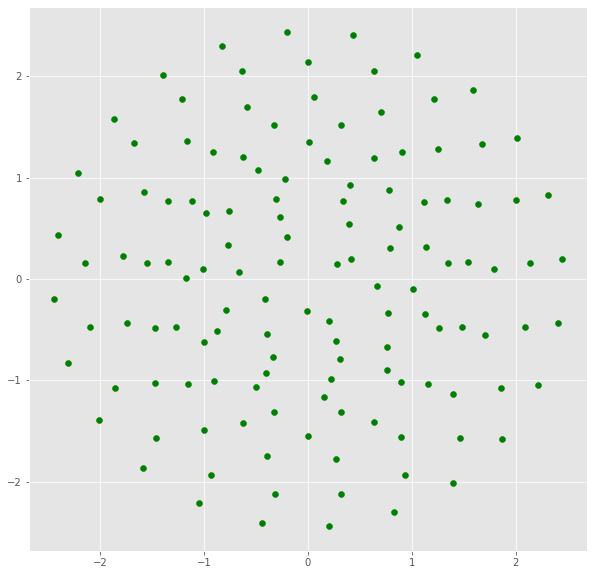

In [32]:
#probability of being outside the circle
alpha = np.array([.95, .9, .8, .7, .6, .5, .4, .3, .2, .1, .05])

#probability radii
radii = np.sqrt(-2 * np.log(alpha))

#number of points on each circle
n_p = np.floor(10 * radii).astype(int)
n_p_tot = sum(n_p)

# angle between points
theta = 2 * np.pi / np.floor(10 * radii)

x_sample = np.zeros(n_p_tot)
y_sample = np.zeros(n_p_tot)
counter = 0
np.random.seed(seed=932)
for i, r in enumerate(radii):
    theta_shift = np.random.rand(1)
    for n in range(n_p[i]):
        th = theta[i] * n + theta_shift
        x_sample[counter] = r * np.cos(th)
        y_sample[counter] = r * np.sin(th)
        counter += 1

plt.figure(figsize = (10, 10))
plt.scatter(x_sample, y_sample, color = 'green')
plt.show()

In [33]:
sampled_corr_mats = np.zeros((n_p_tot, DIM_MAT*DIM_MAT))
for i in range(n_p_tot):
    sample = np.array([x_sample[i], y_sample[i]])
    xp = torch.from_numpy(sample).float()
    mat = myVAE.generate(xp).detach().numpy()
    sampled_corr_mats[i, :] = mat

In [34]:
print(sampled_corr_mats.shape)

(132, 1024)


## Eigenvalues
The points in the latent space have been sampled in circles of increasing radius. Then plotting the 3 largest eigenvalues of the matrices results in subsequent stretches of sinusoids, with increasing amplitude.
The first eigenvalue is in counterphase with the second and third.

In [35]:
L = len(sampled_corr_mats)
eig1 = np.zeros(L)
eig2 = np.zeros(L)
eig3 = np.zeros(L)

for i, corr in enumerate(sampled_corr_mats):
    eigenvals, _ = np.linalg.eig(corr.reshape(DIM_MAT,DIM_MAT))
    eig1[i] = sorted(eigenvals, reverse=True)[0] 
    eig2[i] = sorted(eigenvals, reverse=True)[1] 
    eig3[i] = sorted(eigenvals, reverse=True)[2] 

/tmp/ipykernel_119081/1424081931.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  eig1[i] = sorted(eigenvals, reverse=True)[0]
/tmp/ipykernel_119081/1424081931.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  eig2[i] = sorted(eigenvals, reverse=True)[1]
/tmp/ipykernel_119081/1424081931.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  eig3[i] = sorted(eigenvals, reverse=True)[2]


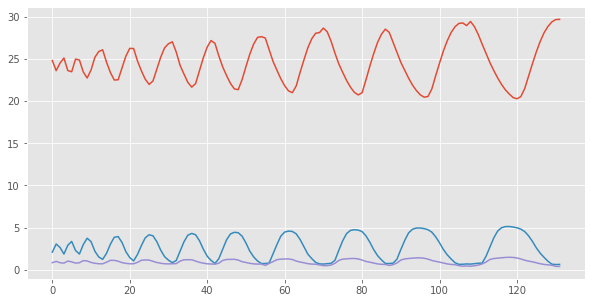

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(eig1)
plt.plot(eig2)
plt.plot(eig3)
plt.show()

## Compute eigenvalues and eigenvectors, for the following analyses

In [37]:
L = len(sampled_corr_mats)

eigval = np.zeros((DIM_MAT, len(sampled_corr_mats)))
eigvec = np.zeros((DIM_MAT, DIM_MAT, len(sampled_corr_mats)))

for i, corr in enumerate(sampled_corr_mats):
    
    vals, vecs = np.linalg.eig(corr.reshape(DIM_MAT,DIM_MAT))
    idx = vals.argsort()[::-1]
    eigval[:, i] = vals[idx]
    eigvec[:, :, i] = vecs[:, idx]

# if possible choose positive sign for eigenvectors
for k in range(len(sampled_corr_mats)): #loop over time
    for j in range(DIM_MAT): #loop over eigenvecs
        if eigvec[1, j, k] < 0:
            eigvec[:, j, k] = - 1 * eigvec[:, j, k]

/tmp/ipykernel_119081/523035653.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  eigval[:, i] = vals[idx]
/tmp/ipykernel_119081/523035653.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  eigvec[:, :, i] = vecs[:, idx]


In [16]:
len(eigval[0,:])

132

In [38]:
overlap = np.zeros(len(sampled_corr_mats) * DIM_MAT)
overlap = overlap.reshape(DIM_MAT, len(sampled_corr_mats))

overlap_l2 = np.zeros(len(sampled_corr_mats) * DIM_MAT)
overlap_l2 = overlap_l2.reshape(DIM_MAT,len(sampled_corr_mats))

for i in range(len(sampled_corr_mats)):
    for j in range(DIM_MAT):  
        overlap[j,i] = np.abs(np.dot(np.mean(eigvec[:, j, :], axis = 1), eigvec[:, j, i]))
        overlap_l2[j,i] = np.abs(np.dot(np.mean(eigvec[:, j, :], axis = 1), eigvec[:, j, i]))

### Save the simulated matrices 

In [18]:
pd.DataFrame(sampled_corr_mats).to_excel("corr_matrices_latent_space_full_sampling.xlsx")